# Time Series Modeling Part1
- 🌟11 Classical Time Series Forecasting Methods in Python (Cheat Sheet). https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- statsmodels.tsa document:https://www.statsmodels.org/dev/tsa.html
- 🌟Forecasting: Principles and Practice.https://otexts.com/fpp3/
- STAT 510 Applied Time Series Analysis https://online.stat.psu.edu/stat510/lesson/2/2.2
- Forecasting and Analytics with ADAM.https://openforecast.org/adam/
- Holt Winter’s Method for Time Series Analysis. https://www.analyticsvidhya.com/blog/2021/08/holt-winters-method-for-time-series-analysis/
- Holt-Winters Exponential Smoothing.https://timeseriesreasoning.com/contents/holt-winters-exponential-smoothing/
- Important Time Series Models:
  - Autoregression(AR)
  - Moving Average(MA)
  - Autoregression Moving Average(ARMA)
  - Autoregressive Integrated Moving Average(ARIMA)
  - Seasonal Autoregressive Integrated Moving Average(SARIMA)
  - Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors(SARIMAX)
  - Vector Autoregression(VAR)
  - Vector Autoregression Moving Average(VARMA)
  - Vector Autoregression Moving Average with Exogenous Regressors(VARMAX)
  - Simple Exponential Smoothing(SES)
  - Holt Winter’s Exponential Smoothing(HWES)



## Decomposing Time Series
- Types of Components
  - Systematic
    - level: mean value in series
    - trend: related with slope
    - seasonality: deviation from mean caused by repeating short-term cycle
  - Non-systematic
    - noise: random variation in series
- Types of Models that are Used for **Decomposing** Time Series
  - Additive
    - form: y(t)=level+trend+seasonality+noise
    - trend is linear, seasonality with same frequency(width) and amplitude(height)
  - Multiplicative 
    - form: y(t)=level * trend * seasonality * noise
    - non-linear trend and seasonality changes.
- For convenience, we do not prefer to deal with multiplicative time series models.
  - Solution: take `log` to make it linear.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
!pip install quandl
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#configuration in quandl
QUANDL_KEY = '-zPmjRGtfXDAyZ3iJJhz'
quandl.ApiConfig.api_key = QUANDL_KEY

In [4]:
#get monthly gold prices from 2011-2022
goldPrice=quandl.get(dataset='WGC/GOLD_MONAVG_USD',start_date='2011-01-01', end_date='2022-12-31')

In [5]:
goldPrice.head()

,Value
Date,
2011-01-31,1356.40
2011-02-28,1372.73
2011-03-31,1424.01
2011-04-29,1473.81
2011-04-30,1473.81


In [6]:
goldPrice.rename(columns={'Value': 'price'}, inplace=True)
goldPrice= goldPrice.resample('M').last() #only keep the price of the last day of the month, for eliminating duplicate values in each month

In [7]:
goldPrice.head()

,price
Date,
2011-01-31,1356.40
2011-02-28,1372.73
2011-03-31,1424.01
2011-04-30,1473.81
2011-05-31,1510.44


<AxesSubplot:title={'center':'Gold Price'}, xlabel='Date'>

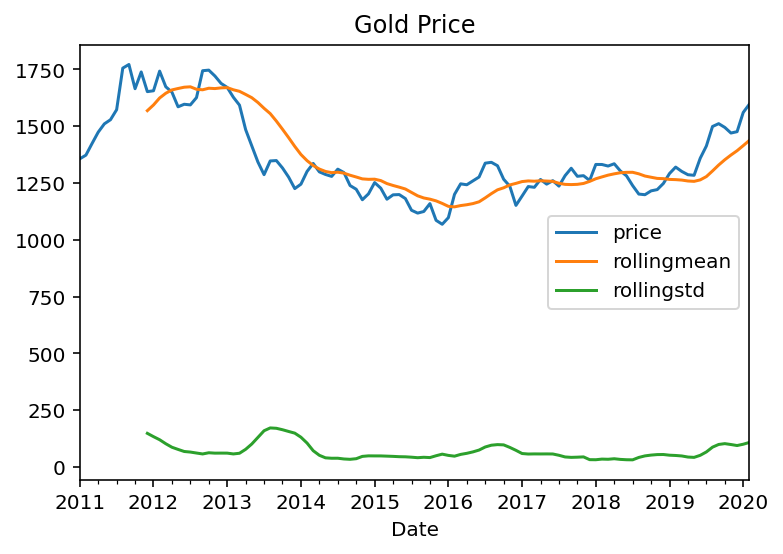

In [8]:
#add the rolling mean and std
goldPrice['rollingmean']=goldPrice.price.rolling(window=12).mean()
goldPrice['rollingstd']=goldPrice.price.rolling(window=12).std()
goldPrice.plot(title='Gold Price')

- Non-linear growth pattern in 12-month moving average, and rolling standard deviation stay in a overall decreasing trend over time.

In [9]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Multiplicative Decomposition')

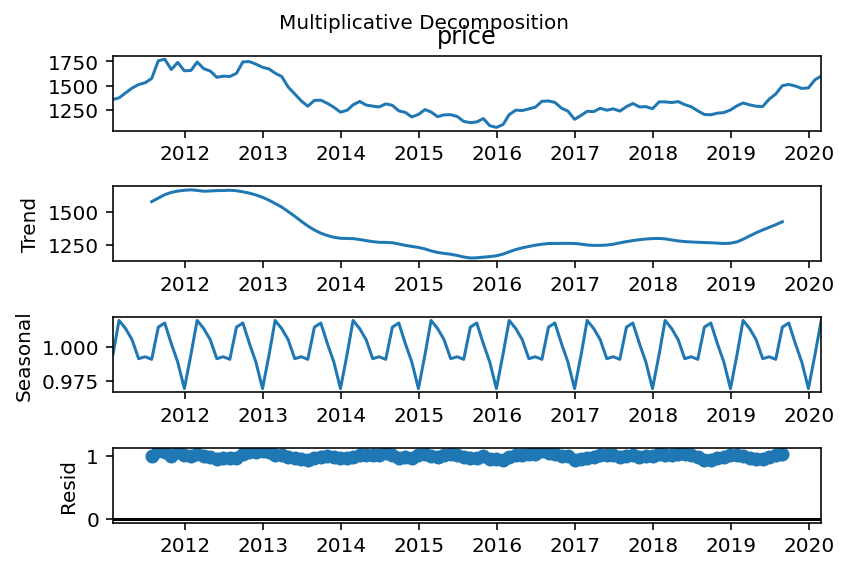

In [10]:
#seasonal decomposition using multiplicative model
decomposition=seasonal_decompose(goldPrice.price, model='multiplicative')
#plot the result
decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=10)

- check if the decomposition make sense: figure out whether residual part is indeed random

### Decomposing Time Series Using Prophet
- Try to fit Prophet's additive model to `daily gold prices` from 2011-2015 and to predict the prices over 2016.

In [11]:
import seaborn as sns
!pip install prophet
from prophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#get dataset from quandl
dailyGoldPrice = quandl.get(dataset='WGC/GOLD_DAILY_USD',start_date='2011-01-01',end_date='2015-12-31')
dailyGoldPrice.reset_index(drop=False, inplace=True)
dailyGoldPrice.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)

In [13]:
#split dataset into training and testing dataset
train_indices = dailyGoldPrice.ds.apply(lambda x: x.year) < 2015 #keep year 2015 prices data as test set.
train =dailyGoldPrice.loc[train_indices].dropna()
test =dailyGoldPrice.loc[~train_indices].reset_index(drop=True)

In [14]:
#build the model
prophet = Prophet(seasonality_mode='additive') 
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5) #added the monthly seasonality
prophet.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ozel7mi/8jhkmnpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ozel7mi/rr0c43hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38946', 'data', 'file=/tmp/tmp3ozel7mi/8jhkmnpk.json', 'init=/tmp/tmp3ozel7mi/rr0c43hq.json', 'output', 'file=/tmp/tmp3ozel7mi/prophet_modeljng1abe5/prophet_model-20230302055531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


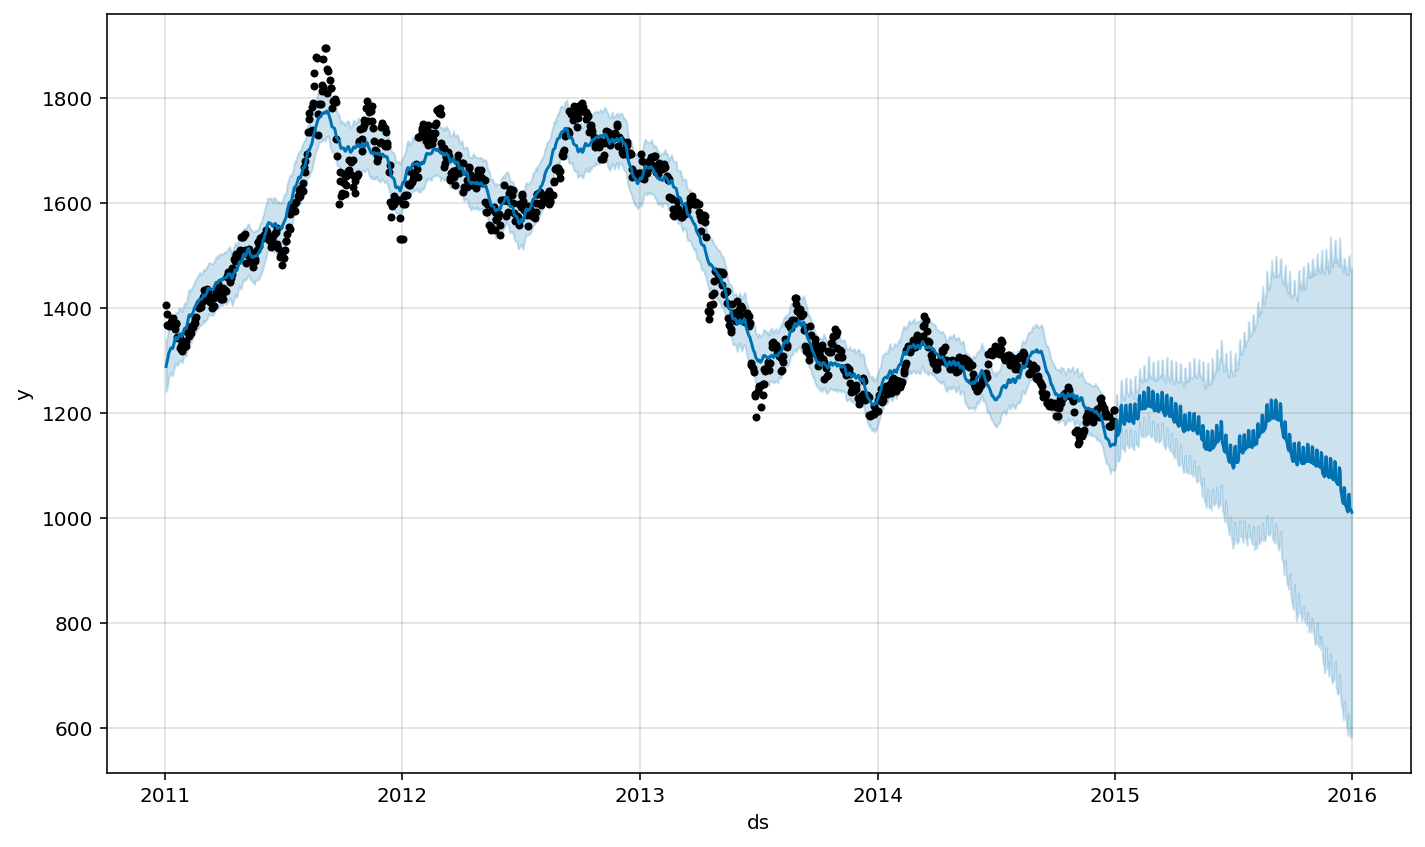

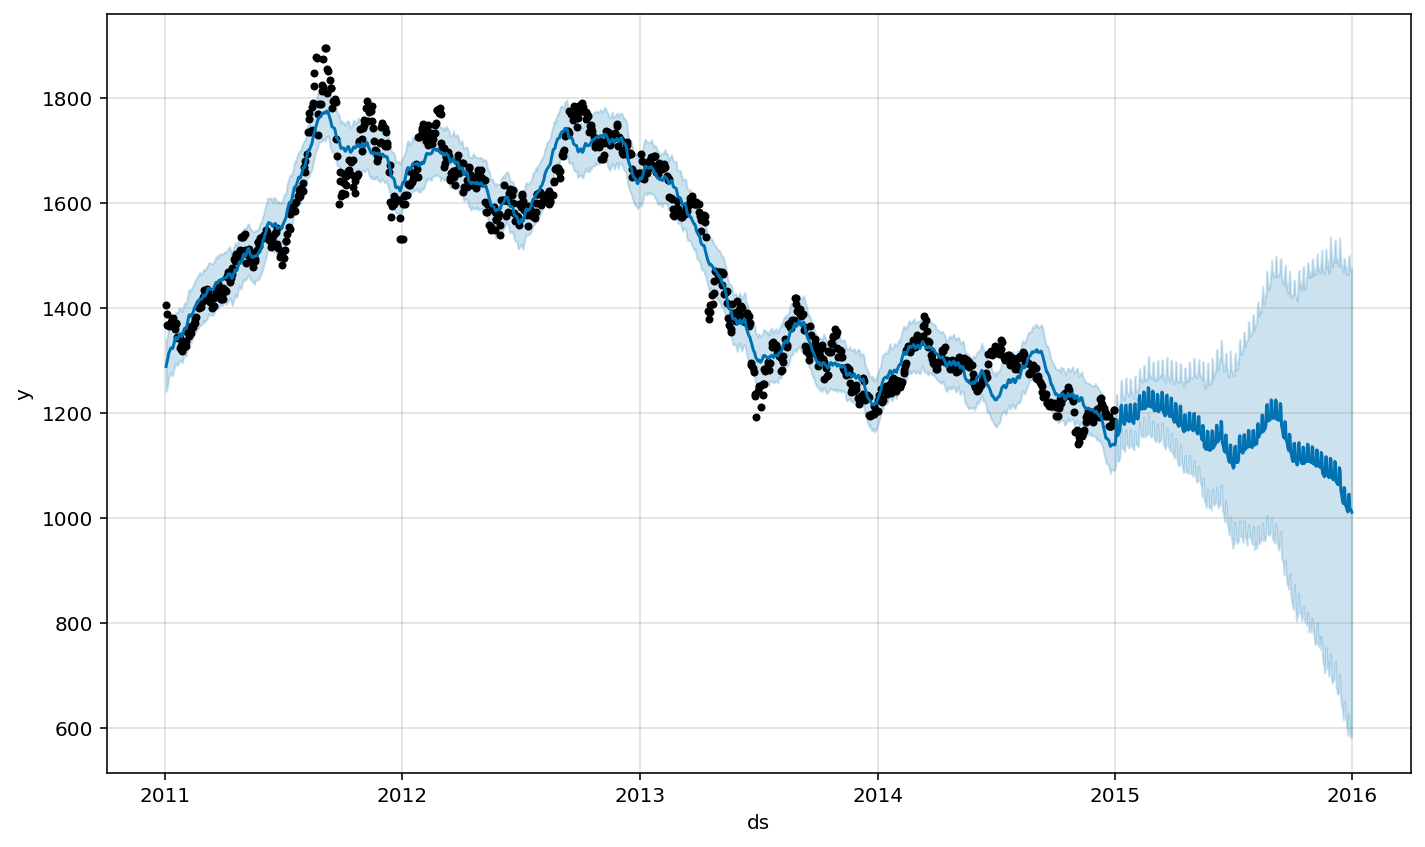

In [15]:
#create forecasting
future = prophet.make_future_dataframe(periods=365) #input how many periods we wanted to obtain using day as unit
pred = prophet.predict(future)
prophet.plot(pred)

- Black dot: actual observations of gold prices
- Blue line: after dropping noises and avoiding overfitting, the fit doesn't match with actual points.

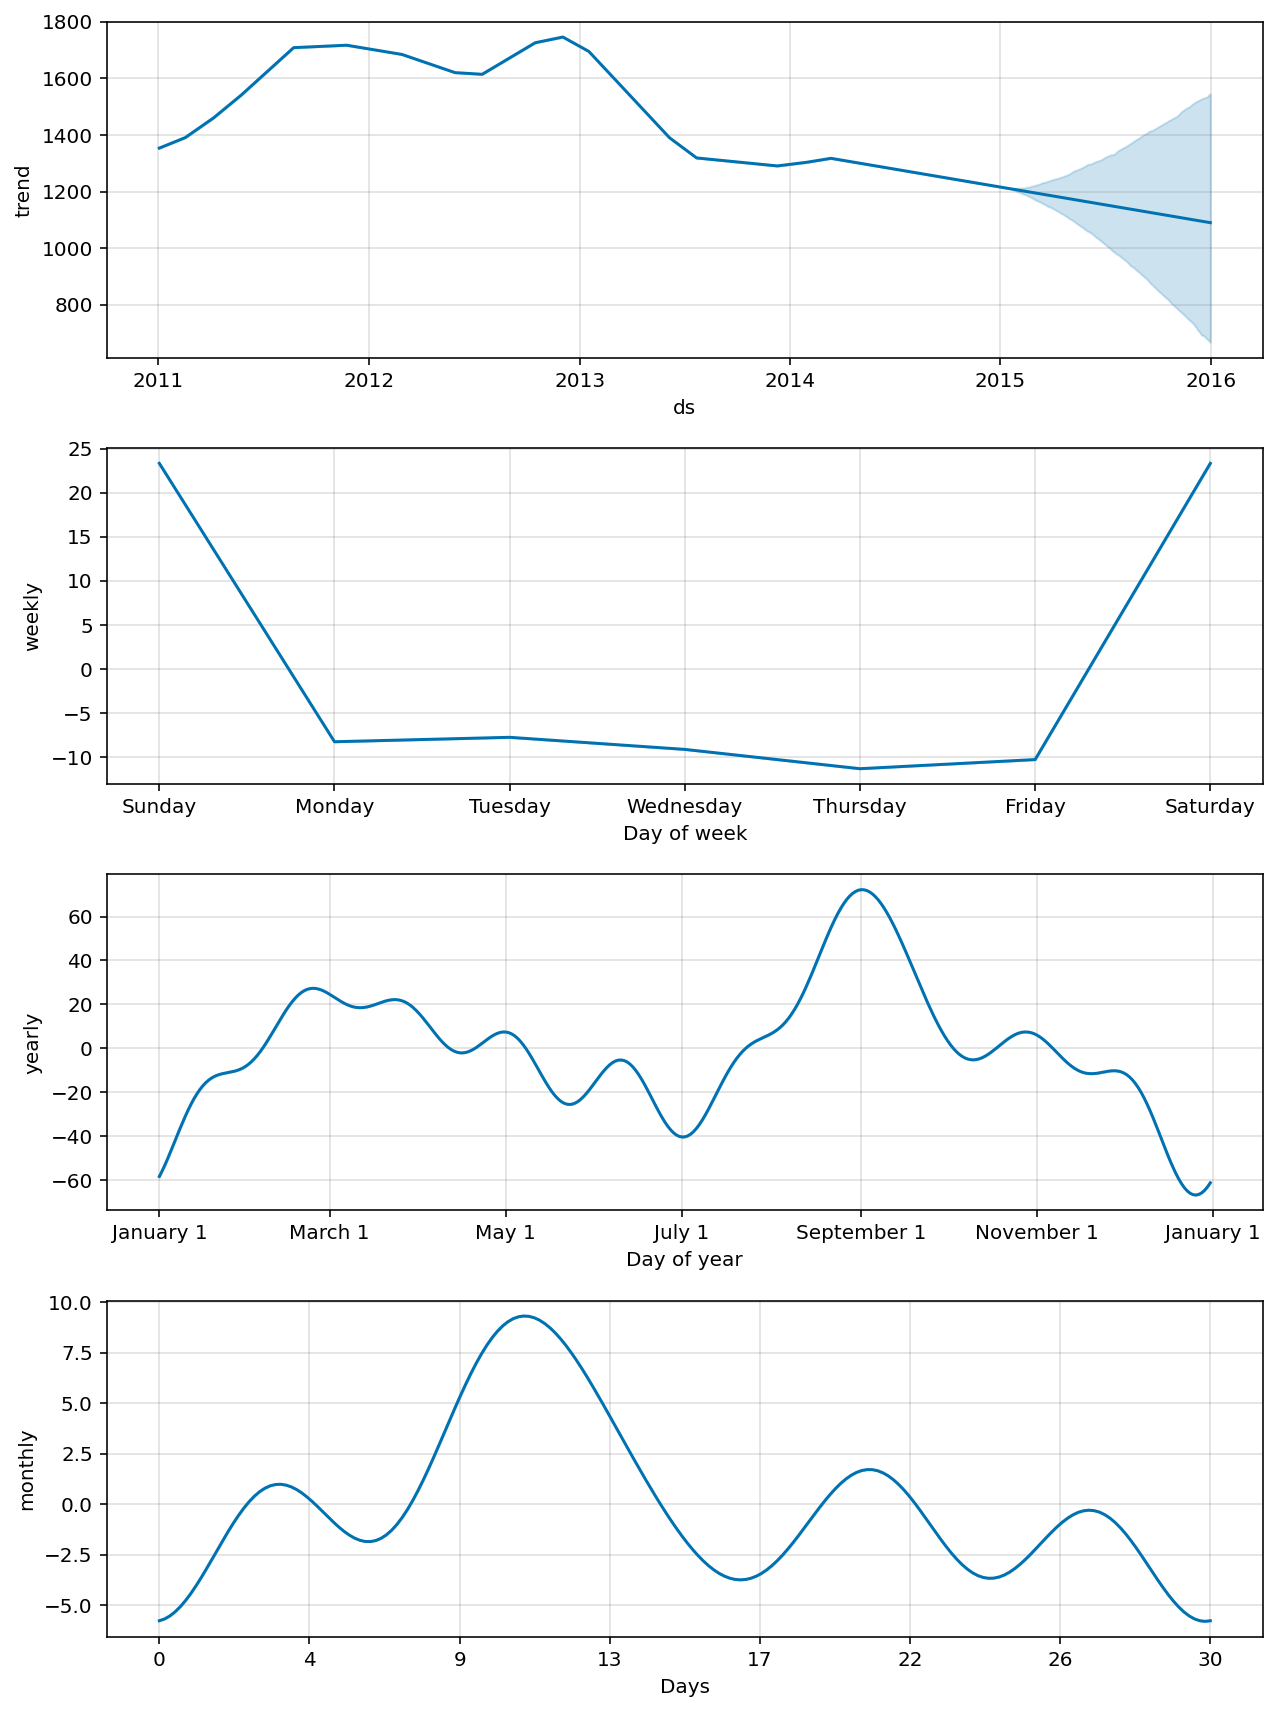

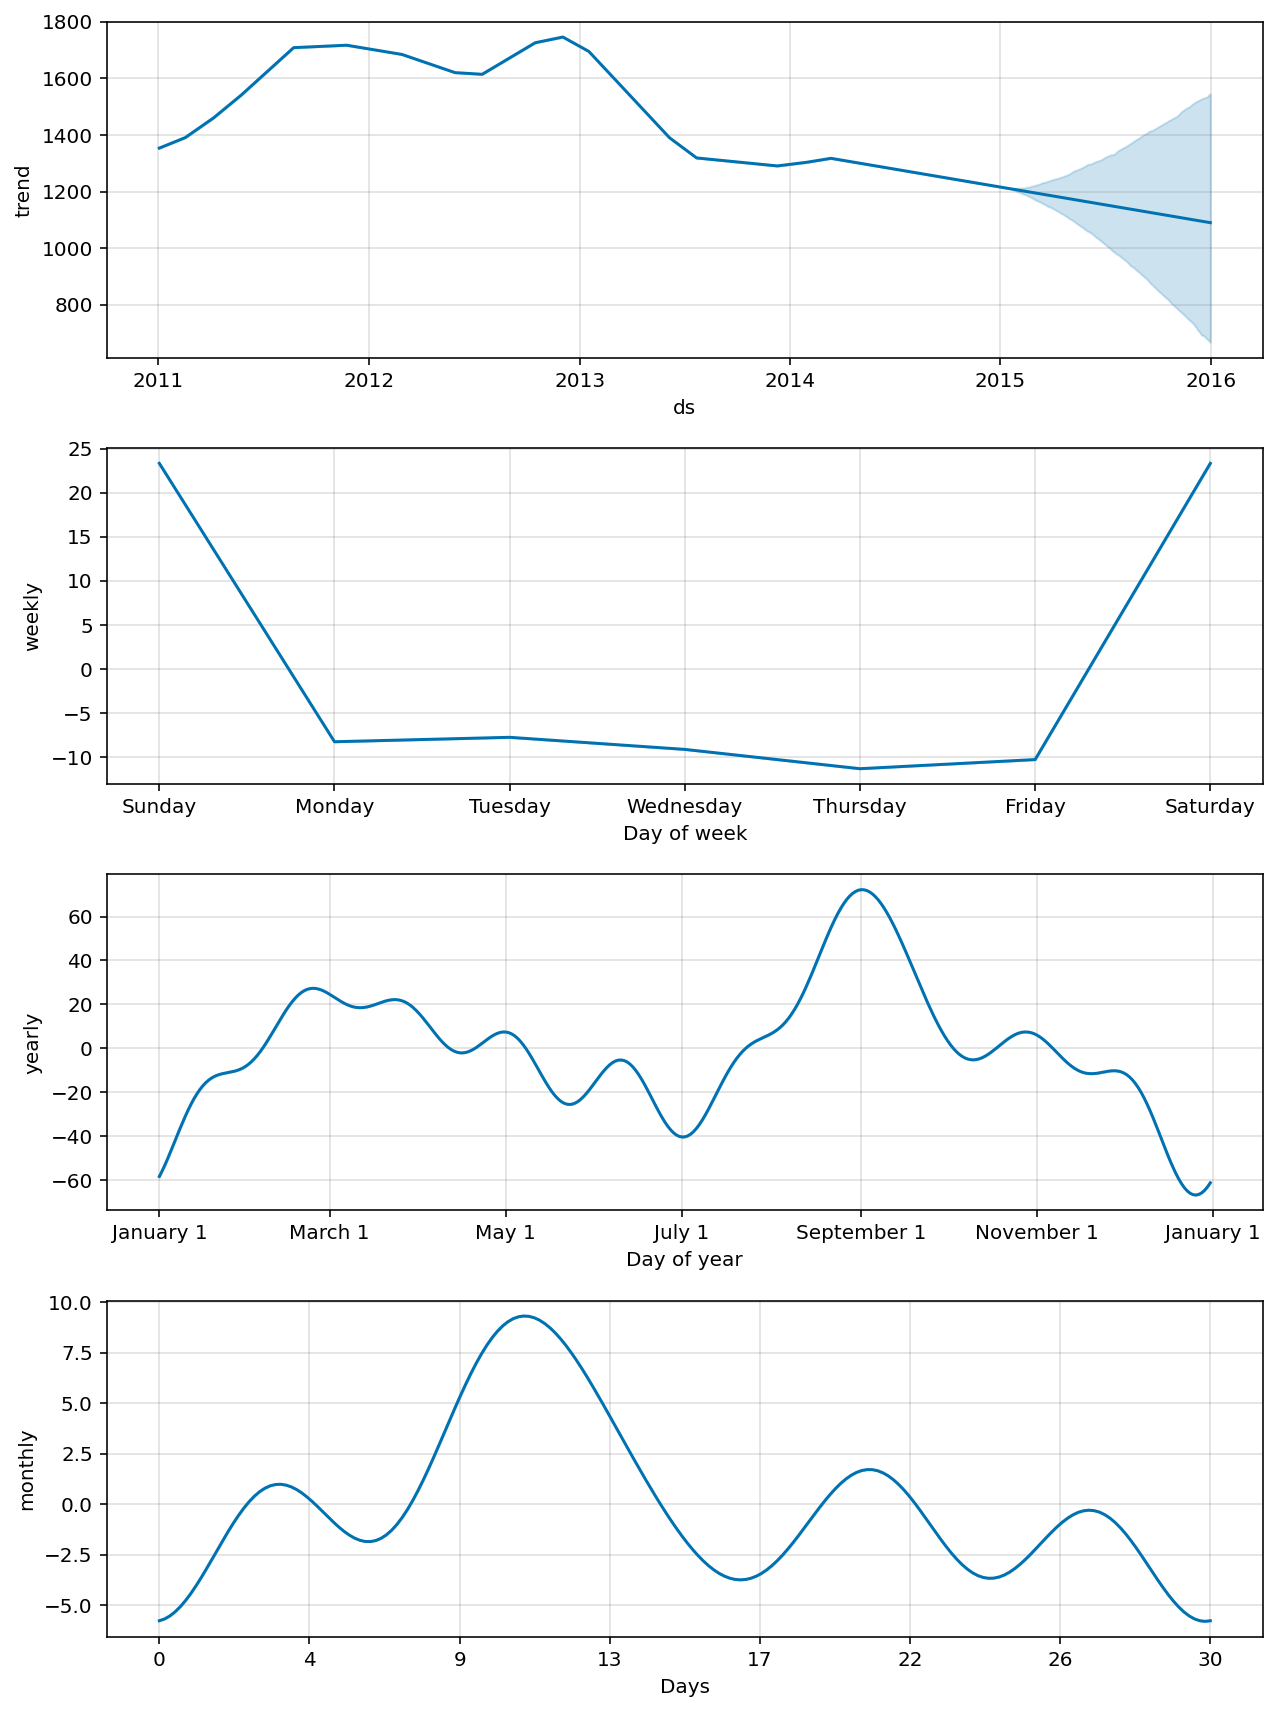

In [16]:
#component decomposition
prophet.plot_components(pred)

- the overall trend is first increasing then decreasing, and in 2016 gold's prices will have a drecreasing trend.
- Prophet shows the trends in different time scales: weekly, monthly, yearly 

### Other Advanced Methods of Decomposition
1. Leoss(locally estimated scatterplot smoothing), **STL Decomposition** to decompose Seasonal and Trend
2. **SEATS Decomposition** with seasonal extraction ARIMA time series
3. **X-11 Decomposition**
- references: https://math.unm.edu/~lil/Stat581/6-decomposition.pdf


### Performance Evaluation of Forecasting

In [17]:
test.head()

,ds,y
0,2015-01-01,1206.00
1,2015-01-02,1172.00
2,2015-01-05,1200.00
3,2015-01-06,1210.25
4,2015-01-07,1210.50


In [18]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-03,1353.638295,1241.662983,1339.074555,1353.638295,1353.638295,-64.398166,-64.398166,-64.398166,-1.852807,...,-8.242851,-8.242851,-8.242851,-54.302509,-54.302509,-54.302509,0.0,0.0,0.0,1289.240129
1,2011-01-04,1354.461001,1247.140086,1341.571134,1354.461001,1354.461001,-59.877193,-59.877193,-59.877193,-0.774687,...,-7.741074,-7.741074,-7.741074,-51.361431,-51.361431,-51.361431,0.0,0.0,0.0,1294.583808
2,2011-01-05,1355.283706,1249.789103,1347.500119,1355.283706,1355.283706,-54.908199,-54.908199,-54.908199,2.468067,...,-9.111239,-9.111239,-9.111239,-48.265026,-48.265026,-48.265026,0.0,0.0,0.0,1300.375507
3,2011-01-06,1356.106412,1257.558245,1357.372102,1356.106412,1356.106412,-50.045024,-50.045024,-50.045024,6.323143,...,-11.300662,-11.300662,-11.300662,-45.067504,-45.067504,-45.067504,0.0,0.0,0.0,1306.061388
4,2011-01-07,1356.929117,1268.356296,1364.188855,1356.929117,1356.929117,-43.212783,-43.212783,-43.212783,8.875917,...,-10.265616,-10.265616,-10.265616,-41.823085,-41.823085,-41.823085,0.0,0.0,0.0,1313.716334


In [19]:
#merge the forecast and test datasets
selected_col=['ds','yhat_lower','yhat_upper','yhat']
pred=pred.loc[:, selected_col].reset_index(drop=True)#recombine as a new pred data
test = test.merge(pred, on=['ds'], how='left') #left join into test dataset
test.ds = pd.to_datetime(test.ds)
test.set_index('ds', inplace=True)

In [20]:
test.head()

,y,yhat_lower,yhat_upper,yhat
ds,,,,
2015-01-01,1206.00,1095.222513,1190.190236,1140.812719
2015-01-02,1172.00,1098.289885,1199.223014,1146.838933
2015-01-05,1200.00,1108.291793,1209.135994,1157.136621
2015-01-06,1210.25,1108.602030,1208.771342,1159.442036
2015-01-07,1210.50,1111.102088,1210.553296,1162.048665


[Text(0.5, 1.0, 'Gold Price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Gold Price ($)')]

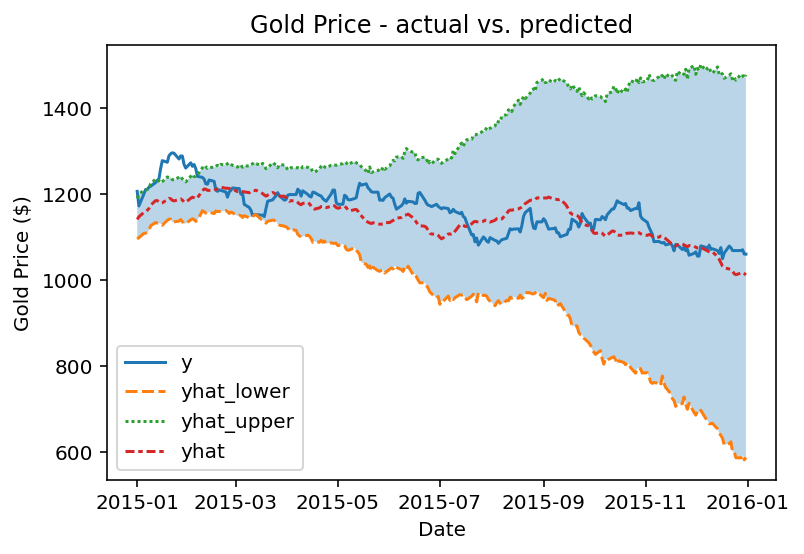

In [21]:
#plot the test values and predictions
ax = sns.lineplot(data=test[['y', 'yhat_lower', 'yhat_upper', 'yhat']])
ax.fill_between(test.index,test.yhat_lower,test.yhat_upper,alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted',xlabel='Date',ylabel='Gold Price ($)')

- From the graph above, we can see Prophet correctly predict the gold prices in 2015, except the first two months which are outside of confidence interval.

## Testing for Stationary in Time Series
- reference:https://otexts.com/fpp2/stationarity.html
- Stationary lines: mean, variance, covariance are almost **constant** over time.
- Significance: makes modeling and forecasting more feasible
- Drawback of non-stationary data:
  - variance misspecified by model
  - worse model fit
  - cannot leverage valuable time-dependent patterns in data.
- Methods to test stationary:
  1. Augmented Dickey-Fuller (**ADF**) test
    - For stationary time series,the ACF will <u>drop to zero</u> relatively quickly.
    - for non-stationary time series, **r1** is often <u>extremely large and positive</u>.
  2. Kwiatkowski-Phillips-Schmidt-Shin (**KPSS**) test
      - determine the presence of **unit root** in the series
        - unit root test: to determine whether `differencing` is required
  3. (partial) autocorrelation function (**PACF/ACF**)

In this case, we still use the data from 2011/01/01-2022/12/31 monthly gold prices.

- references: 
  - https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
  - Statistical tests to check stationarity in Time Series – Part 1.https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [23]:
#define the ADF test function
def adf_test(x):
  '''
  H0: the time series is sationary
  H1: the time series is not sationary

  AIC: Akaike Information Criterion, the numbers of lag selected from. Besides, we can select it manually.
  '''
  adf_test = adfuller(x, autolag='AIC') 
  results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'Numbers of Lags Used', 'Numbers of Observations Used'])
  for key, value in adf_test[4].items():
      results[f'Critical Value ({key})'] = value

  return results

In [24]:
adf_test(goldPrice.price)

Test Statistic                   -1.782649
p-value                           0.389109
Numbers of Lags Used              5.000000
Numbers of Observations Used    104.000000
Critical Value (1%)              -3.494850
Critical Value (5%)              -2.889758
Critical Value (10%)             -2.581822
dtype: float64

- From the results, we have no reason to reject the null hypothesis, meaning that we can conclude that <u>the series is not stationary</u>.

In [25]:
#define a function for KPSS test
def kpss_test(x, h0_type='c'):
  '''
  H0: the time series is sationary
  H1: the time series is not sationary

  c: the data is stationary and around a constant, level stationary
  ct: the data is stationary around the trend
  '''
  indices = ['Test Statistic', 'p-value', 'Numbers of Lags']
  kpss_test = kpss(x, regression=h0_type)
  results = pd.Series(kpss_test[0:3], index=indices)
  for key, value in kpss_test[3].items():
      results[f'Critical Value ({key})'] = value

  return results

In [26]:
kpss_test(goldPrice.price)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


Test Statistic            0.379036
p-value                   0.086192
Numbers of Lags          13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

-  Comparing the p-value and significant levels, we have reasons to reject the null hypothesis in favor of the alternative one, meaning that <u>the series is not stationary</u>.

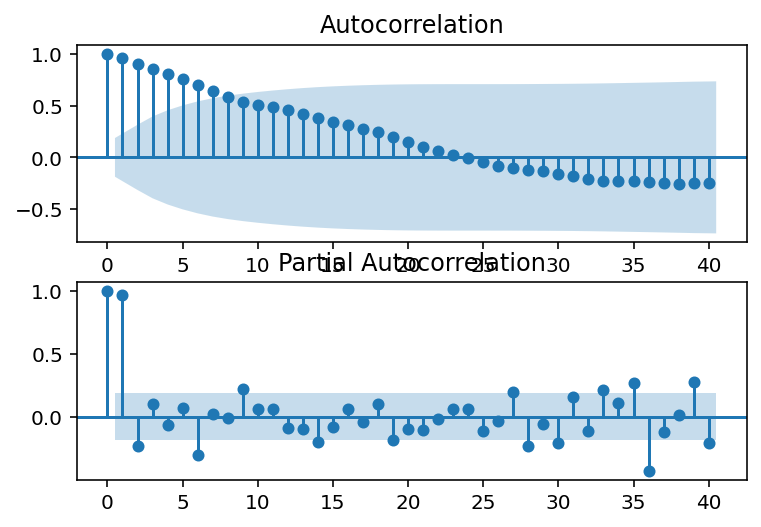

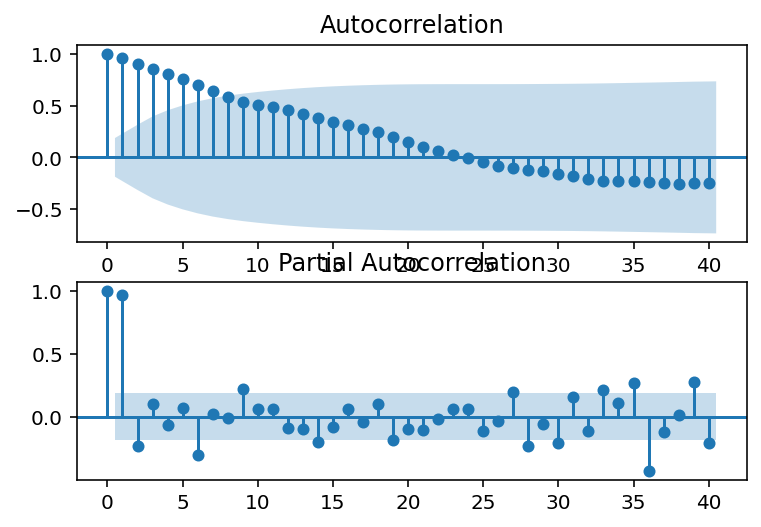

In [27]:
#plot the ACF/PACF
fig, ax = plt.subplots(2, 1)
plot_acf(goldPrice.price, ax=ax[0], lags=40, alpha=0.05)
plot_pacf(goldPrice.price, ax=ax[1], lags=40, alpha=0.05)

- From the autocorrelation, there are significant autocorrelations above the confidence interval.
- There are also some significant autocorrelations in the PACF plot.


- Autocorrelation: 
  - Definition: measure the linear relationship between `lagged values` of a time series.Namely, the relationship between current and past valus.
  - autocorrelation coefficient:$r_k=\frac{\sum_{t=k+1}^T(y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^T(y_t-\bar{y})^2}$
    - $T$: length of the time series
    - $k$:lag
    - range:$[-1,1]$
  - Check how much past prices for a security have on future price.

## Correcting for Stationarity in Time Series
- use the data previously download from quandl
- cpi document: https://palewi.re/docs/cpi/

In [28]:
!pip install cpi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.2/30.2 MB 18.2 MB/s eta 0:00:00


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
import warnings

# settings 
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
warnings.simplefilter(action='ignore', category=InterpolationWarning)
plt.style.use('seaborn')

def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'], kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

In [31]:
import cpi
from datetime import date

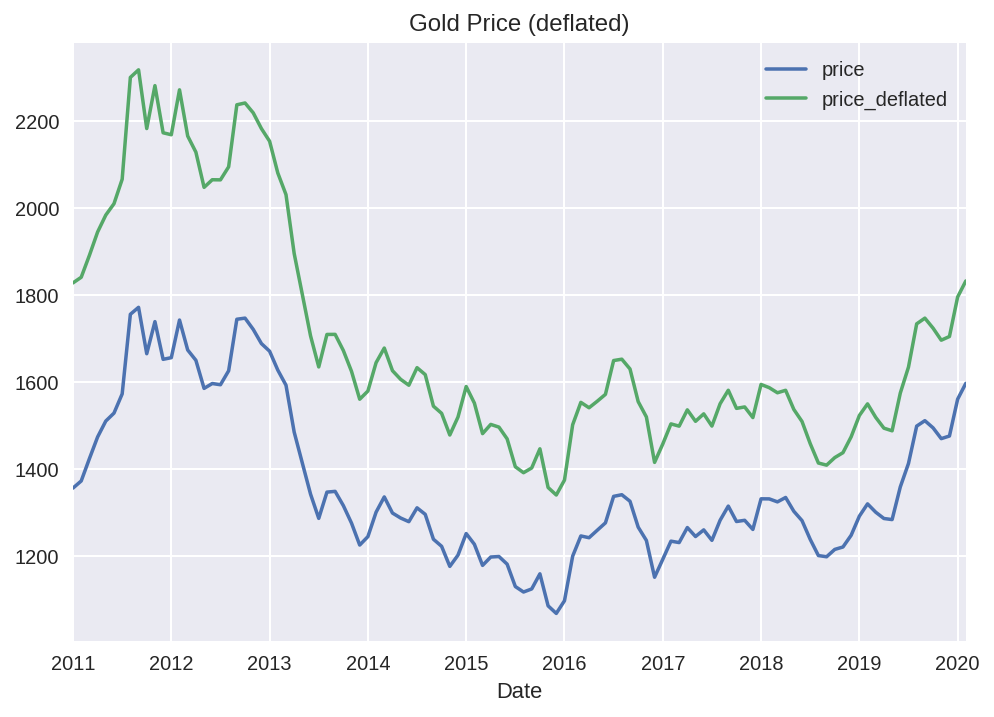

In [33]:
#deflate the gold prices
date_def=date(2022,12,31)
goldPrice['dt_index']=goldPrice.index.map(lambda x: x.to_pydatetime().date()) #manually get index
goldPrice['price_deflated'] = goldPrice.apply(lambda x: 
                                     cpi.inflate(x.price,x.dt_index, date_def), axis=1) #the dollar value we want to adjust, 
goldPrice[['price', 'price_deflated']].plot(title='Gold Price (deflated)');

In [36]:
goldPrice.head()

,price,rollingmean,rollingstd,dt_index,price_deflated
Date,,,,,
2011-01-31,1356.40,NaN,NaN,2011-01-31,1828.035450
2011-02-28,1372.73,NaN,NaN,2011-02-28,1840.965102
2011-03-31,1424.01,NaN,NaN,2011-03-31,1891.294446
2011-04-30,1473.81,NaN,NaN,2011-04-30,1944.912037
2011-05-31,1510.44,NaN,NaN,2011-05-31,1983.918061


<AxesSubplot:title={'center':'Gold Price(logged)'}, xlabel='Date'>

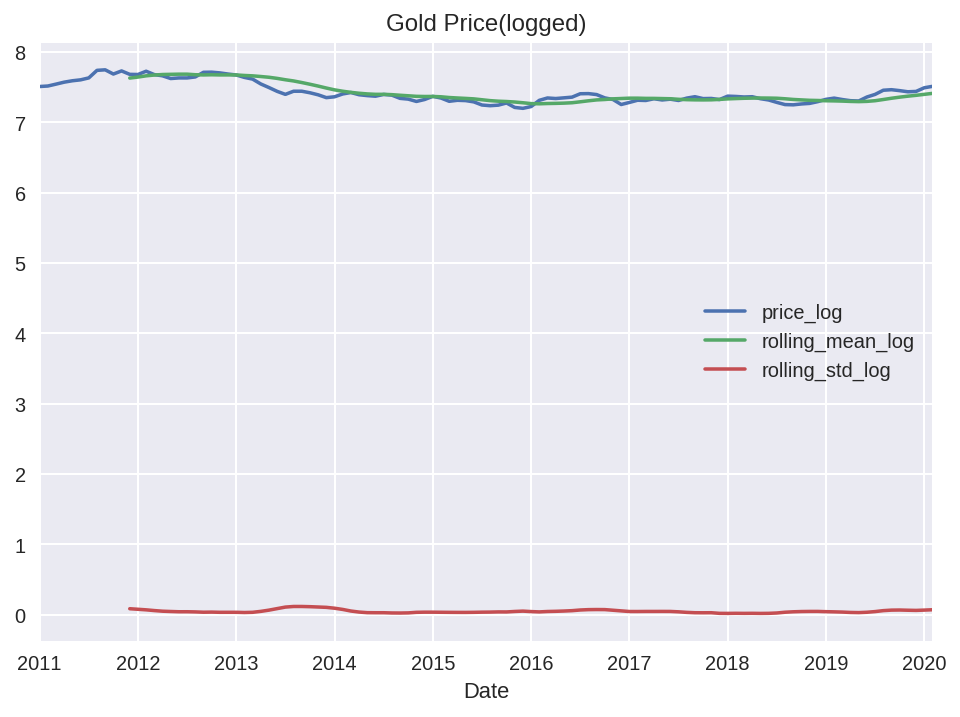

In [38]:
#deflate the series using natrual log to make the exponential trend linear and plot with rolling metrics
import numpy as np
goldPrice['price_log']=np.log(goldPrice.price_deflated)
goldPrice['rolling_mean_log']=goldPrice.price_log.rolling(window=12).mean()
goldPrice['rolling_std_log']=goldPrice.price_log.rolling(window=12).std()
selected_columns=['price_log','rolling_mean_log','rolling_std_log']
goldPrice[selected_columns].plot(title='Gold Price(logged)')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ADF test statistic: -1.82 (p-val: 0.37)
KPSS test statistic: 0.54 (p-val: 0.03)


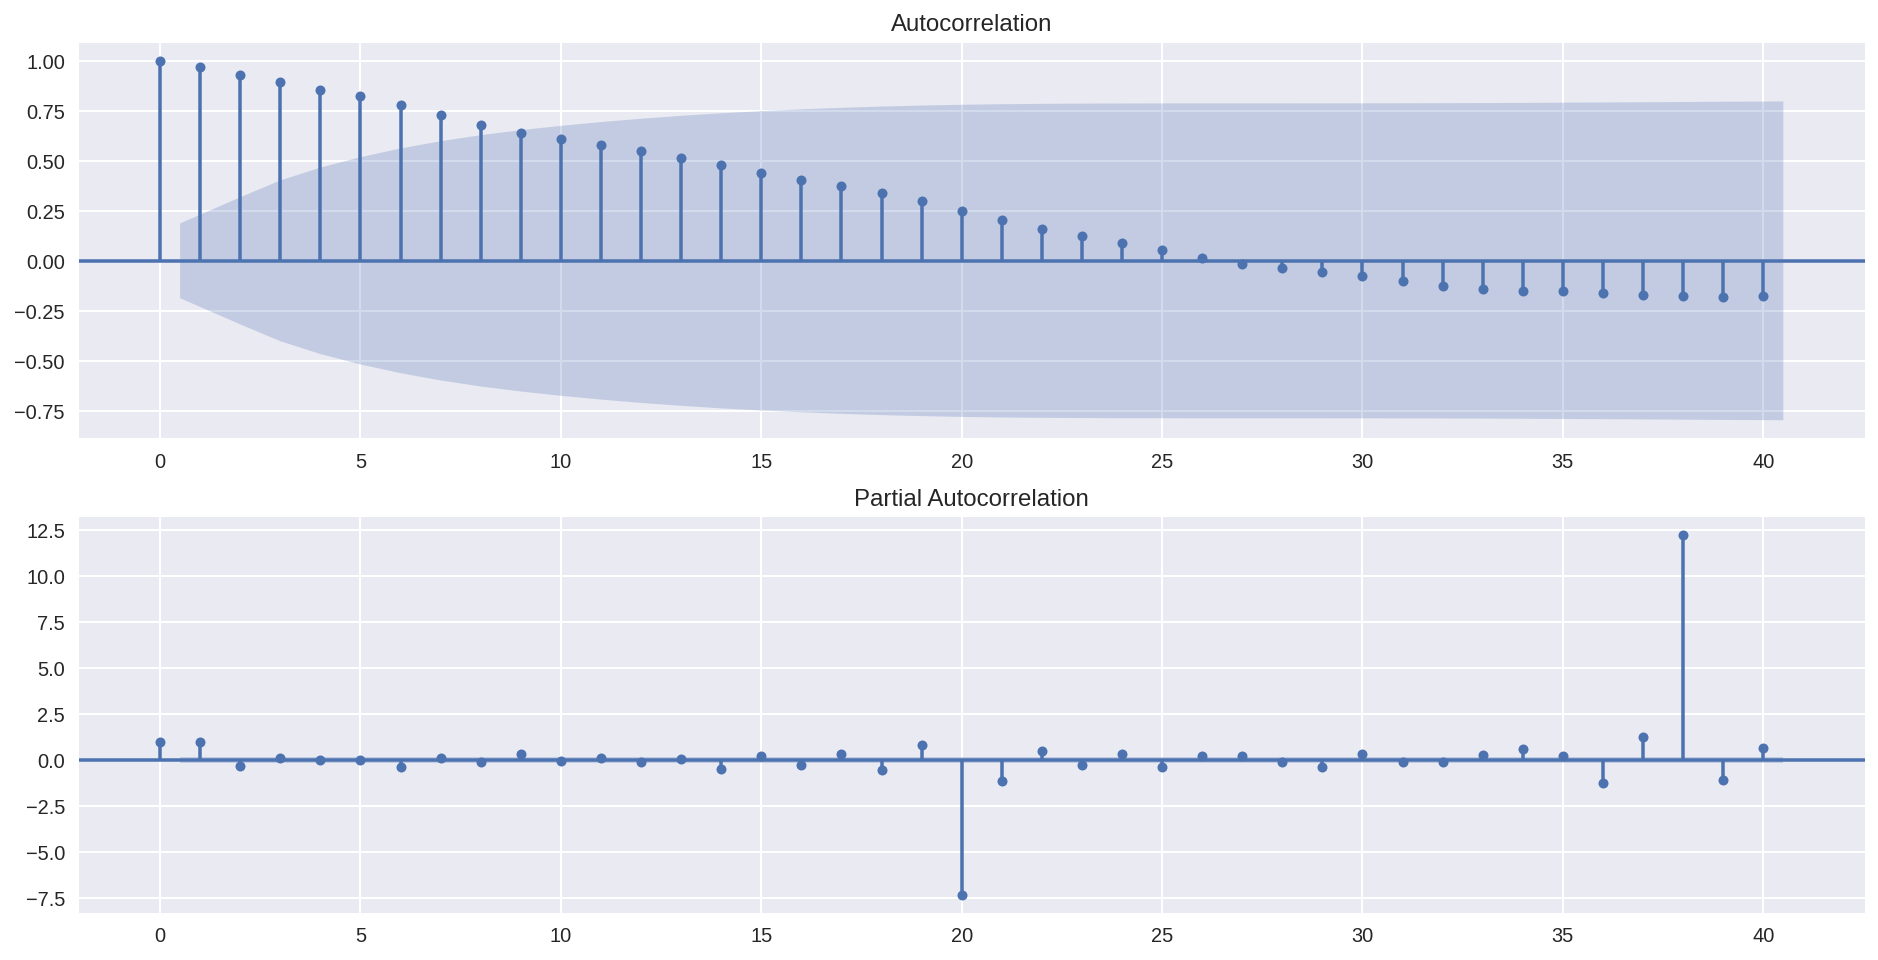

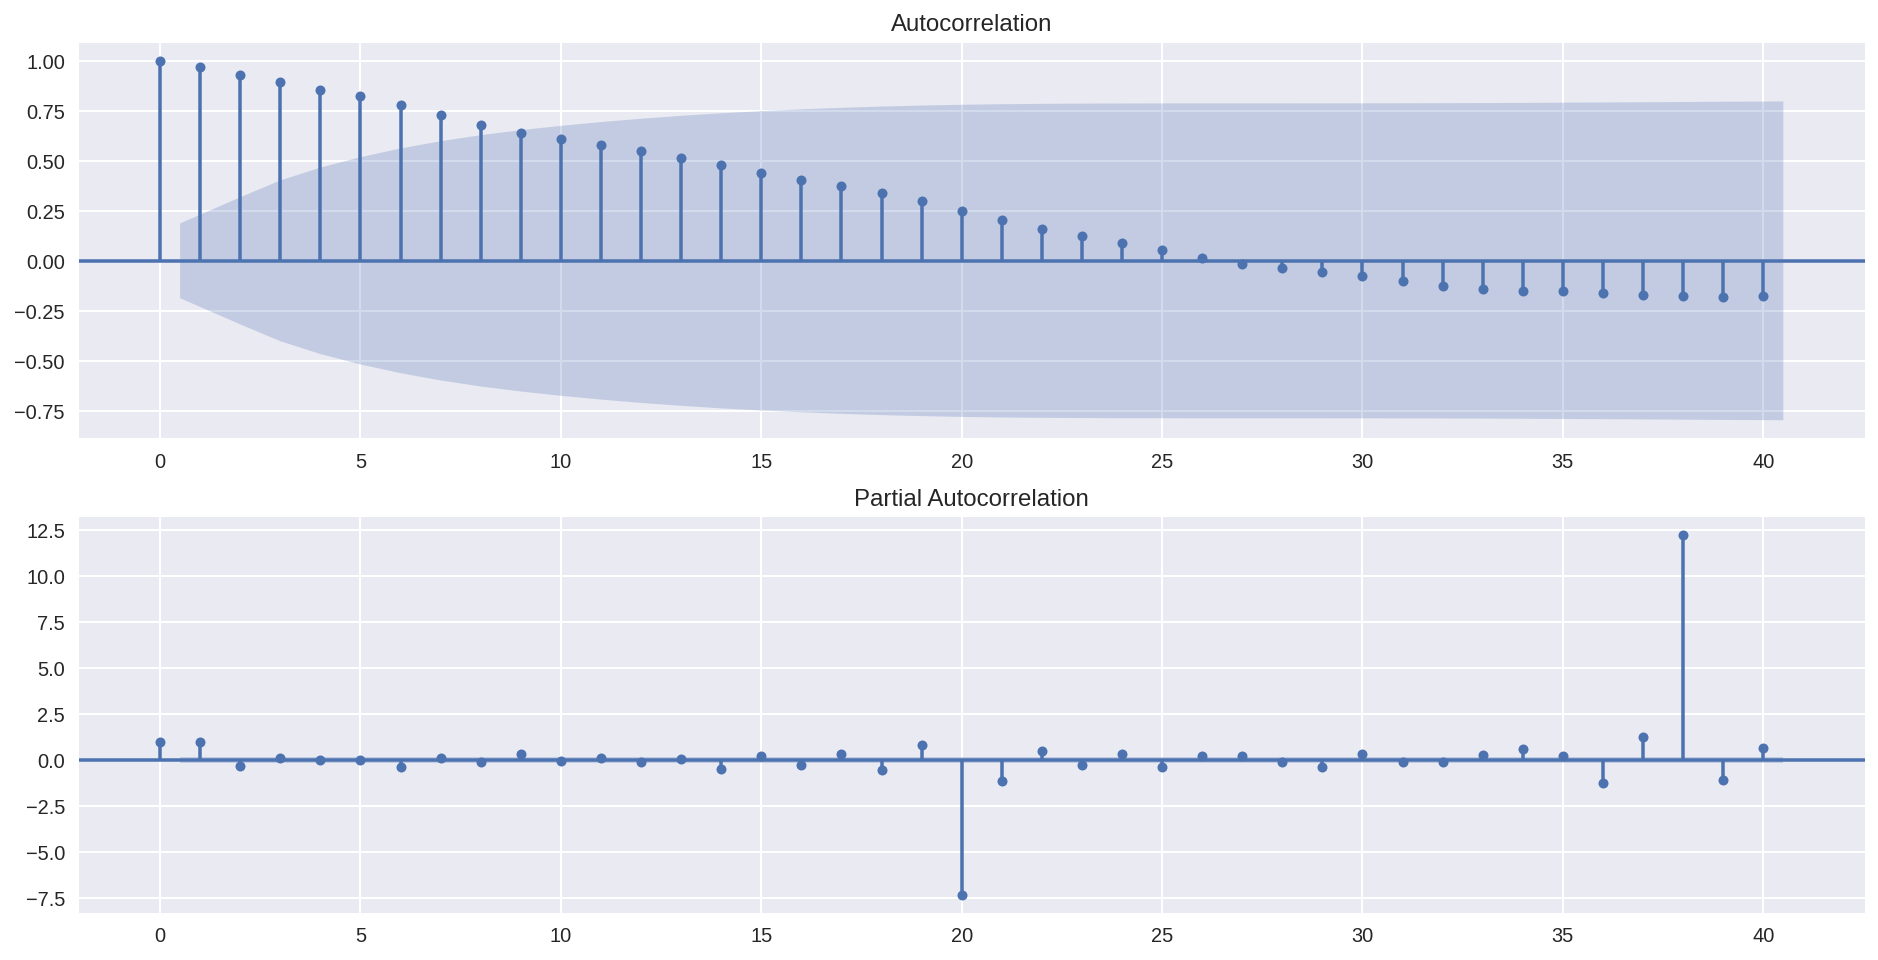

In [39]:
#test whether the series is stationary
test_autocorrelation(goldPrice.price_log)

- The autocorrelation test shows that the deflated natrual log process is not to make the gold price stationary.

#### Differencing
- A way to make non-stationary series stationary
- help stabilize the **mean** of a time series by removing changes in the level of a time series. Therefore it eliminates trend and seasonality.

<AxesSubplot:title={'center':'Gold Price(differences)'}, xlabel='Date'>

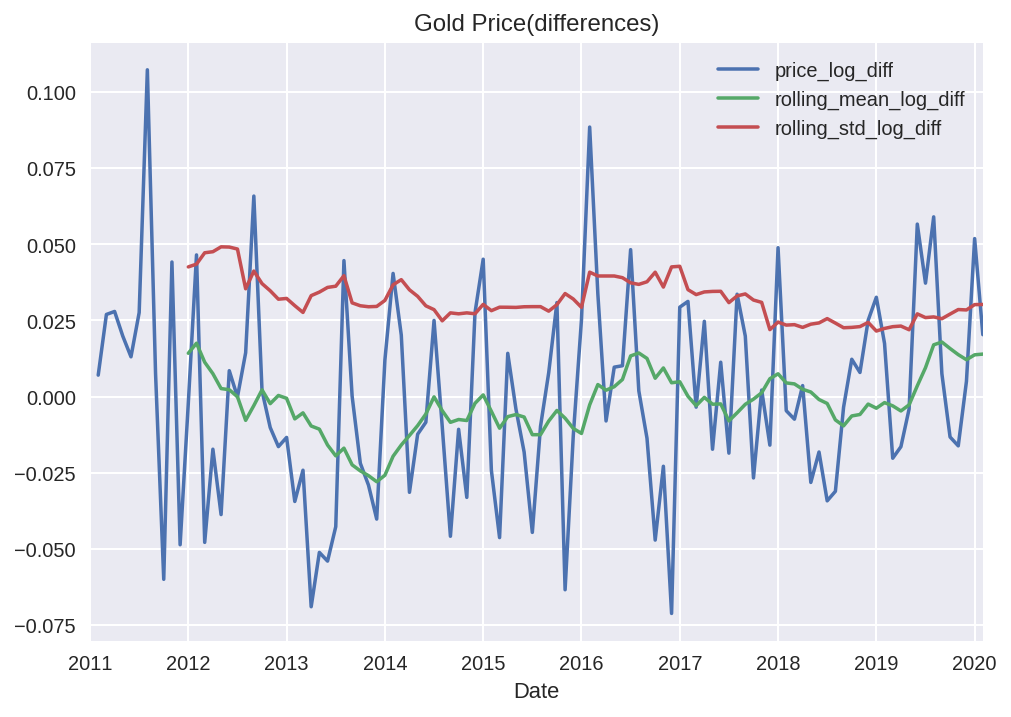

In [40]:
#calculating the difference between the value in time t and time t-1, and plot it
goldPrice['price_log_diff']=goldPrice.price_log.diff(1)
goldPrice['rolling_mean_log_diff']=goldPrice.price_log_diff.rolling(window=12).mean()
goldPrice['rolling_std_log_diff']=goldPrice.price_log_diff.rolling(window=12).std()
selected_columns=['price_log_diff','rolling_mean_log_diff','rolling_std_log_diff']
goldPrice[selected_columns].plot(title='Gold Price(differences)')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


ADF test statistic: -3.71 (p-val: 0.00)
KPSS test statistic: 0.19 (p-val: 0.10)


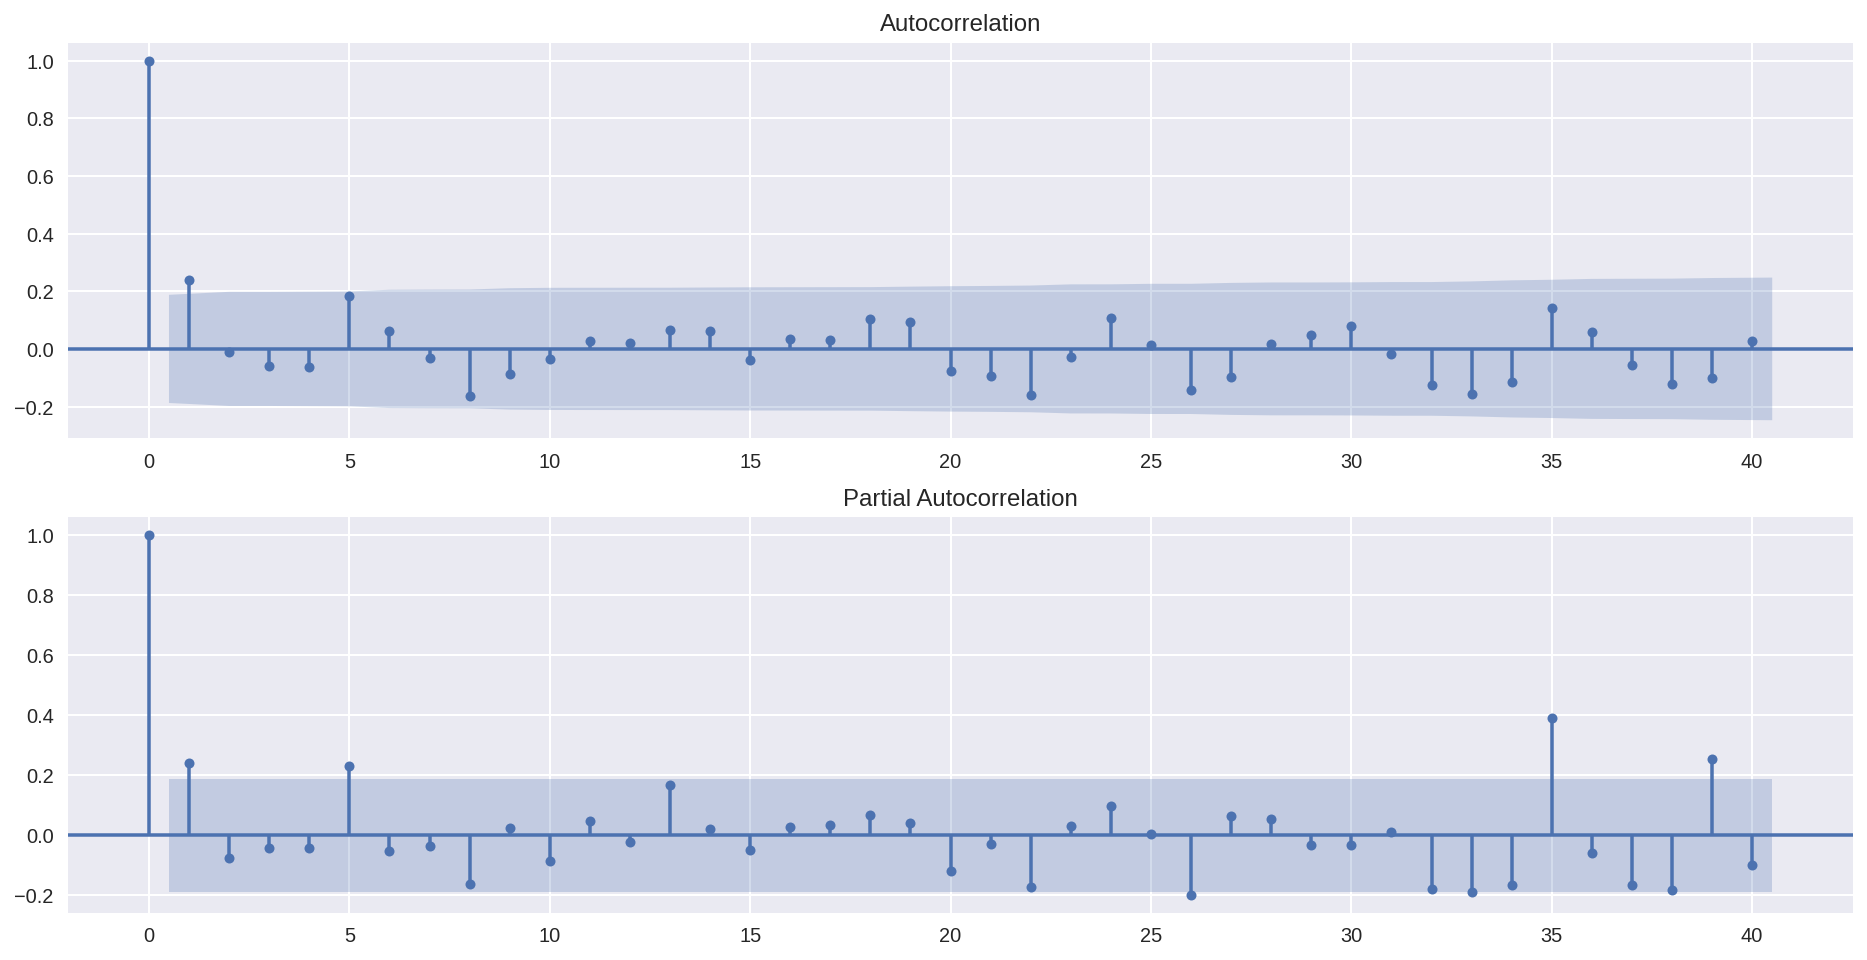

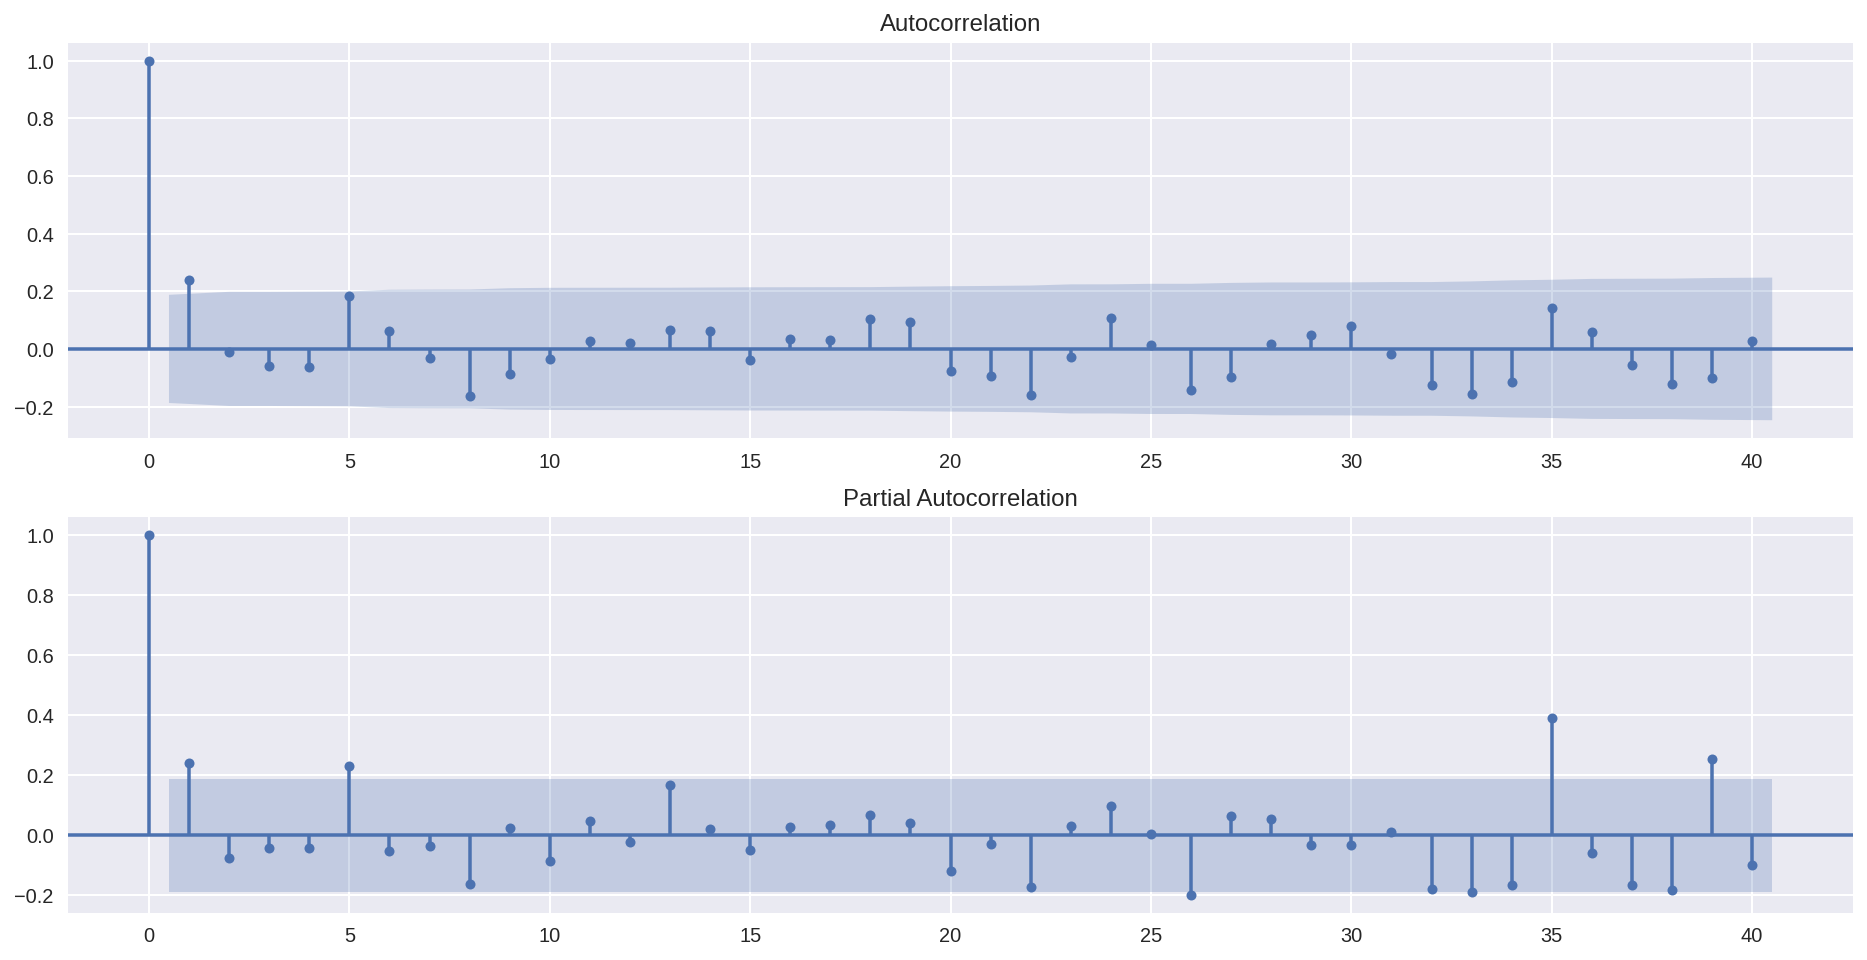

In [41]:
#autocorrelation test the differencing whether make time series to be stationary
test_autocorrelation(goldPrice.price_log_diff.dropna())

#### Other Correcting Methods:
- Use Random Walk model
- Second order differencing
- Seasonal differencing

## Modeling Time Series with Exponential Smoothing Methods
1. Simple Exponential Smoothing (SES)
2. Holt's Winter Exponential Smoothing(EWES) Linear Trend

We use Google 2010-2017 price data to forecast 2018 data.

### Simple Exponential Smoothing
- Formula: $\hat{y_{t+1}}=\hat{\alpha}y_t+(1-\hat{\alpha})\hat{y_t}$
  - $\alpha$: smoothing parameter 
    - range $(0,1)$
    - a weight between the latest actual value and the one-step-ahead predicted one.
    - Small $\alpha$, more weight is given to the $\hat{y_t}$ the previous predicted one, new information is more neglected.
    - if $\alpha=0$, the future value equals to average of historical data
    - if $\alpha=1$, all the forecasts have the same value as the last observation in the training data.
- Rewirte the function: $\hat{y_{t+1}}=\hat{\alpha}\sum_{j=0}^{t-1}(1-\hat{\alpha})^j*y_{t-j}+(1-\hat{\alpha})\hat{y_1}$

In [43]:
#use cubehelix for color
import seaborn as sns
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')
COLOR=[plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]] # color codes for red/green/blue/gray.

<Figure size 576x396 with 0 Axes>

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt
#https://www.statsmodels.org/stable/tsa.html#exponential-smoothing

In [49]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [51]:
#get adjusted Google stock price data from yahoo finance
googPrice=yf.download('GOOG',start='2010-01-01',end='2018-12-31',progress=False)

In [52]:
googPrice.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313


In [53]:
#keep the monthly closing stock price only
GOOG = googPrice.resample('M').last().rename(columns={'Adj Close': 'adj_close'}).adj_close 

In [54]:
GOOG.head()

Date
2010-01-31    13.199027
2010-02-28    13.120820
2010-03-31    14.125056
2010-04-30    13.093423
2010-05-31    12.095413
Freq: M, Name: adj_close, dtype: float64

In [57]:
#get the train/test split data
goog_train = GOOG[GOOG.index.year < 2018] #2010~2017
goog_test = GOOG[GOOG.index.year == 2018] #2018
test_length = len(goog_test) #the number of periods we want to forecast for later in model building

In [73]:
print(test_length)

12


In [58]:
goog_test.head()

Date
2018-01-31    58.497002
2018-02-28    55.236500
2018-03-31    51.589500
2018-04-30    50.866501
2018-05-31    54.249500
Freq: M, Name: adj_close, dtype: float64

In [59]:
goog_train.head()

Date
2010-01-31    13.199027
2010-02-28    13.120820
2010-03-31    14.125056
2010-04-30    13.093423
2010-05-31    12.095413
Freq: M, Name: adj_close, dtype: float64

<AxesSubplot:title={'center':'GOOG Stock Price'}, xlabel='Date'>

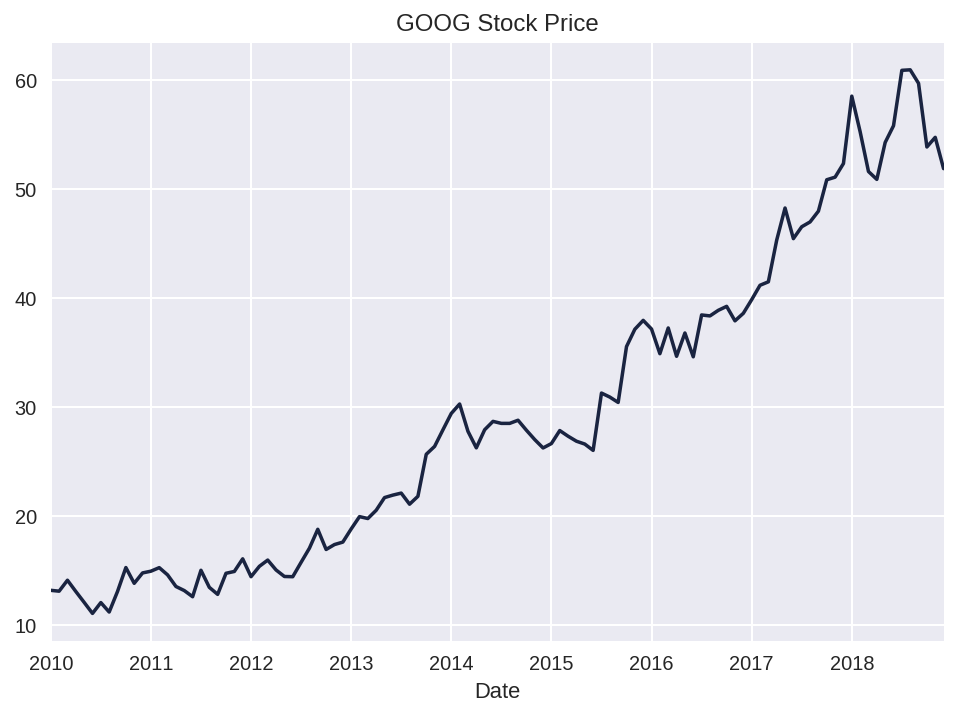

In [60]:
#plot the prices
GOOG.plot(title="GOOG Stock Price")

In [61]:
#plot three SES model for forecasting with different smooth paramters
SES1=SimpleExpSmoothing(goog_train).fit(smoothing_level=0.2)
SESForecast1 = SES1.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [62]:
SES2=SimpleExpSmoothing(goog_train).fit(smoothing_level=0.5)
SESForecast2 = SES2.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [63]:
SES3 = SimpleExpSmoothing(goog_train).fit()
alpha = SES3.model.params['smoothing_level'] #let statsmodel lib automatically get the optimal parameter value, by minimizing SSE
SESForecast3 = SES3.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:title={'center':'Simple Exponential Smoothing'}, xlabel='Date'>

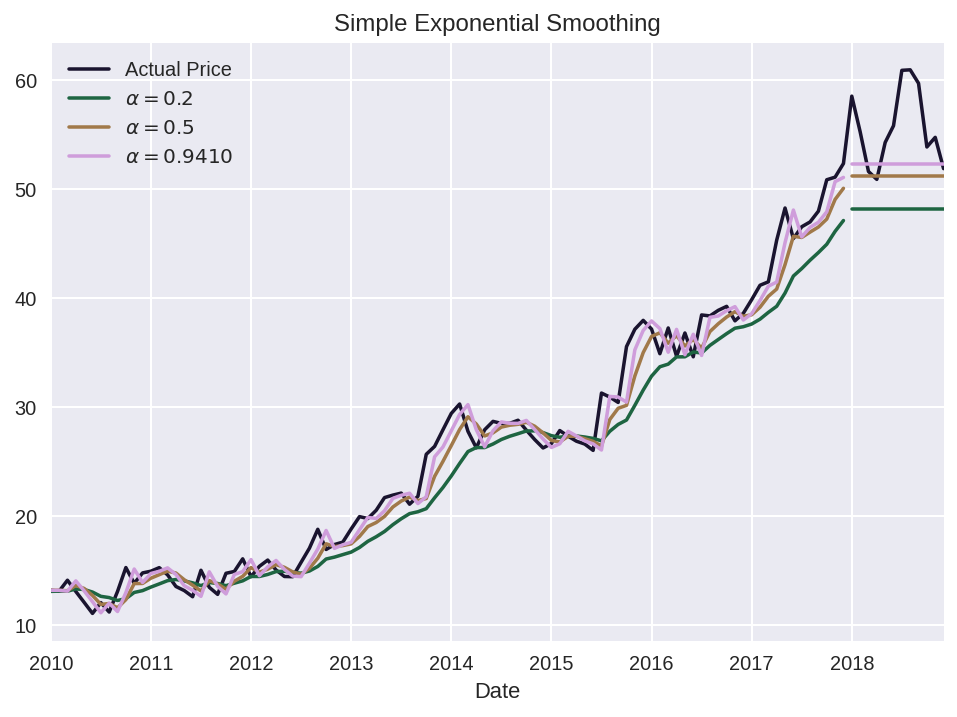

In [65]:
#plot the forecasting results of three models above
GOOG.plot(color=COLOR[0], title='Simple Exponential Smoothing', legend=True, label='Actual Price') #a benchmark for comparison

SESForecast1.plot(color=COLOR[1], legend=True, label=r'$\alpha=0.2$')
SES1.fittedvalues.plot(color=COLOR[1])

SESForecast2.plot(color=COLOR[2], legend=True, label=r'$\alpha=0.5$')
SES2.fittedvalues.plot(color=COLOR[2])

SESForecast3.plot(color=COLOR[3], legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))
SES3.fittedvalues.plot(color=COLOR[3])

- The forecast is a flat line
- The optimal value of alpha selected by statsmodels near 1(0.941)

### Holt(Trend) Winter(Seasonality) Exponential Smoothing 
- Formula: 
  - Multiplicative: $T_{i+1}=(L_i+B_i)*S_{i+1-m}*N_{i+1}$
  - Addicitve: $T_{i+1}=(L_i+B_i)+S_{i+1-m}+N_{i+1}$
    - $(L_i+B_i)$: Estimated level at (i+1)
    - $S_{i+1-m}$: Estimated seasonal variation at seasonal step(i-1+m)
    - $N_{i+1}$: observed noise
- Holt with linear trend
  - Forecast: $\hat{y_{t+h|t}}=l_t+hb_t$
    - level: $l_t=\alpha y_t+(1-\alpha)(l_{t-1}+b_{t-1})$
    - trend: $b_t=\beta^* (l_t-l_{t-1})+(1-\beta^* )b_{t-1}$
      - $\beta^*$:smoothing parameter of trend 
- Holt with Damped Trend 
  - Forecast: $\hat{y_{t+h|t}}=l_t+(𝜱+𝜱^2+𝜱^3+...+𝜱^h)b_t$
    - level: $l_t=\alpha y_t+(1-\alpha)(l_{t-1}+𝜱b_{t-1})$
    - trend: $b_t=\beta^* (l_t-l_{t-1})+(1-\beta^* )𝜱b_{t-1}$
    - 𝜱: dampen the trend to a flat line(constant) in the long-term future
      - if 𝜱=1, the forecast function equalize the Holt linear trend
      - 𝜱 rarely less than 0.8
- Holt Winter with Seasonality
  - Addictive method
    - $\hat{y_{t+h|t}}=l_t+hb_t+s_{t+h-m(k+1)}$
      - Season: $s_t=𝛄(y_t-l_{t-1}-b_{t-1})+(1-𝛄)s_{t-m}$
      - Level: $l_t=\alpha(y_t-s_{t-m})+(1-\alpha)(l_{t-1}+b_{t-1})$
      - trend: $b_t=\beta^* (l_t-l_{t-1})+(1-\beta^* )b_{t-1}$
        - 𝛄: smoothing parameter for seasonality
        - $m$:  the period of the seasonality, namely the number of seasons in a year. If m=4, quarterly data. If m=12, monthly data.
    - For each year with addictive method, seasonal components <u>sum up to 0</u>, which are expressed by `absolute terms`.
    - is preferred when seasonal variatons are roughly constant.
  - Multiplicative method
    - $\hat{y_{t+h|t}}=(l_t+hb_t)s_{t+h-m(k+1)}$
      - Level: $l_t=\alpha \frac{y_t}{s_{t-m}}+(1-\alpha)(l_{t-1}+b_{t-1})$
      - trend: $b_t=\beta^* (l_t-l_{t-1})+(1-\beta^* )b_{t-1}$
      - Season: $s_t=𝛄 \frac{y_t}{l_{t-1}+b_{t-1}}+(1-𝛄)s_{t-m}$
    - For each year with multiplicative method, seasonal components <u>sum up to m</u>, which are expressed by `percentage`.
    - is preferred when seasonal variations are changing proportional to the level of series.
  - Damped Method
    - $\hat{y_{t+h|t}}=[l_t+(𝜱+𝜱^2+𝜱^3+...+𝜱^h)b_t]*s_{t+h-m(k+1)}$
      - level: $l_t=\alpha \frac{y_t}{s_{t-m}}+(1-\alpha)(l_{t-1}+𝜱b_{t-1})$
      - trend: $b_t=\beta^* (l_t-l_{t-1})+(1-\beta^* )𝜱b_{t-1}$
      - season: $s_t=𝛄 \frac{y_t}{l_{t-1}+𝜱b_{t-1}}+(1-𝛄)s_{t-m}$
    - Damping is possible with both *additive and multiplicative* Holt-Winters’ methods. Above, we only show the multiplicative method.

In [71]:
##create 3 Holt smoothing trend train models and make forecasts. https://otexts.com/fpp2/holt.html
#Holt with linear trend
HS1 = Holt(goog_train).fit()
HSForecast1 = HS1.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [74]:
#Holt with exponential trend
HS2 = Holt(goog_train,exponential=True).fit()
HSForecast2 = HS2.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [68]:
#Holt with trend damping 
HS3 = Holt(goog_train, exponential=False,damped=True).fit(damping_slope=0.99)
HSForecast3 = HS3.forecast(test_length)

<ipython-input-68-c40fbd45e5aa>:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  HS3 = Holt(goog_train, exponential=False,damped=True).fit(damping_slope=0.99)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:title={'center':"Holt's Smoothing models"}, xlabel='Date'>

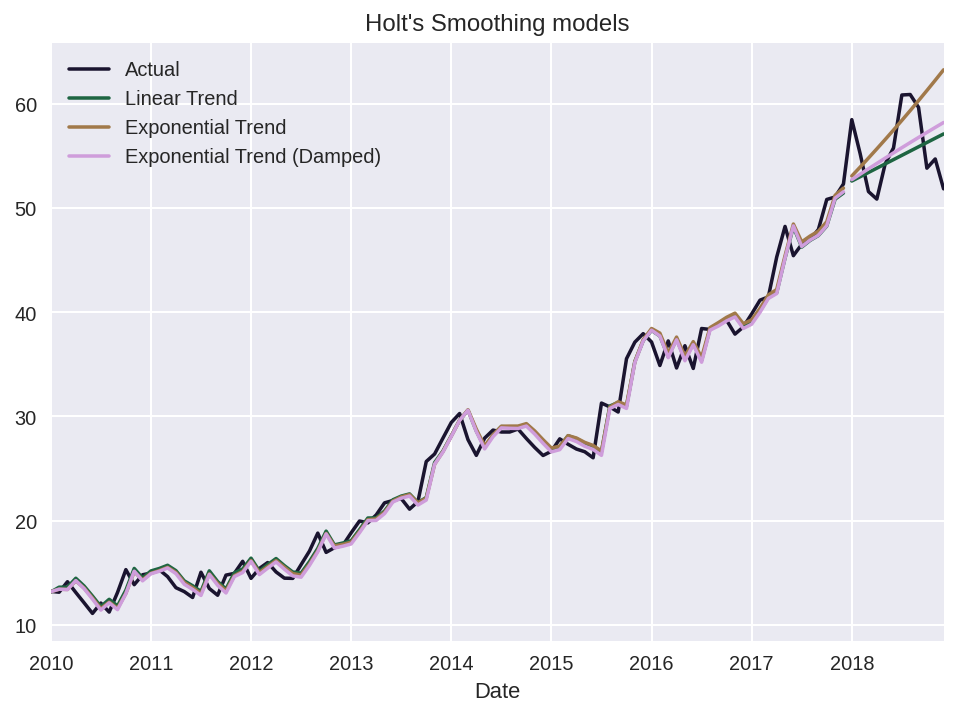

In [75]:
#plot in graphs
GOOG.plot(color=COLOR[0], title="Holt's Smoothing models",label='Actual',legend=True) 

HSForecast1.plot(color=COLOR[1], legend=True, label='Linear Trend')
HS1.fittedvalues.plot(color=COLOR[1])

HSForecast2.plot(color=COLOR[2], legend=True, label='Exponential Trend')
HS2.fittedvalues.plot(color=COLOR[2])

HSForecast3.plot(color=COLOR[3], legend=True, label='Exponential Trend (Damped)')
HS3.fittedvalues.plot(color=COLOR[3])

In [77]:
#Holt-Winter Seasonal Smoothing with exponential trend
HW1 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', seasonal_periods=12).fit()
HWForecast1 = HW1.forecast(test_length)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [78]:
#Holt-Winter Seasonal Smoothing with exponential trend and damping
HW2 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', seasonal_periods=12,damped=True).fit()
HWForecast2 = HW2.forecast(test_length)

<ipython-input-78-533e767c7ea6>:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  HW2 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', seasonal_periods=12,damped=True).fit()
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:title={'center':"Holt-Winter's Seasonal Smoothing"}, xlabel='Date'>

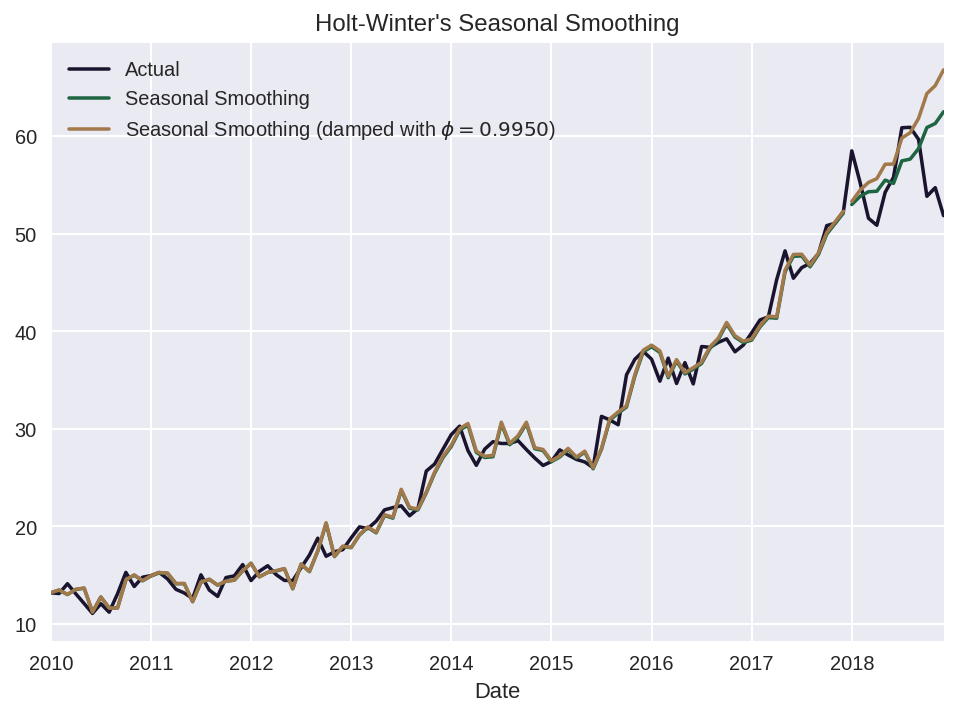

In [82]:
#plot the actual value and models' forecasting result
GOOG.plot(color=COLOR[0],title="Holt-Winter's Seasonal Smoothing",label='Actual',legend=True)

HW1.fittedvalues.plot(color=COLOR[1])
HWForecast1.plot(color=COLOR[1], legend=True, label='Seasonal Smoothing')

phi = HW2.model.params['damping_trend'] #optimize with statsmodel find the specific value
HW2.fittedvalues.plot(color=COLOR[2])
HWForecast2.plot(color=COLOR[2], legend=True, label=f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)')

- The model forecasting results are more flexible than SES and Holter's Linear trend models.

## Modeling Time Series with ARIMA Class Models
### AR
### MA
### ARIMA